## 1. Сгенерировать пакетом hopfield-tracking датасет spdsim с параметрами по умолчанию

In [1]:
import vispy
# selecting sub-backend behind jupyter_rfb:
# 1) pyglfw has high priority if present
# 2) to use any other backend, install then designate as default
# 4) use jupyter_rfb, it then selects the sub-backend according to config
# 5) enable jupyterlab extensions for interactive widget provided by jupyter_rfb

# only needed in jhub2, jhub and jlab-hpc can't run opengl at all, locally auto-selected backend is OK
vispy.config.update(default_backend='egl')
vispy.use('jupyter_rfb')

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
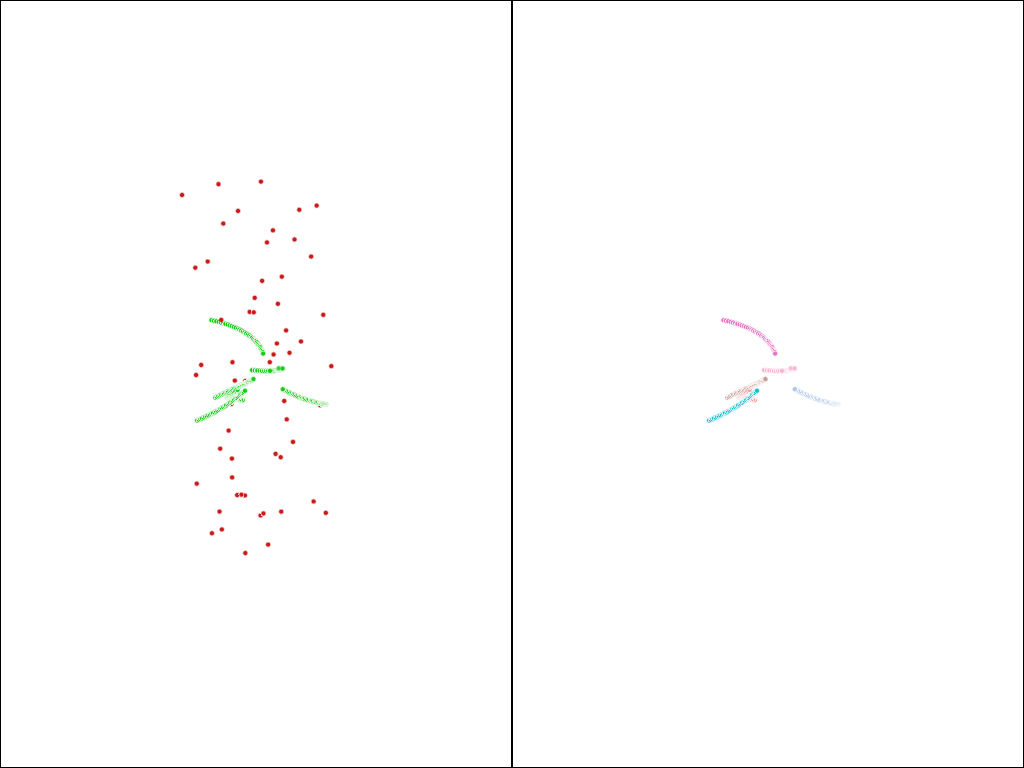

In [9]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
plot_event(event)

In [10]:
event

,x,y,z,layer,track,event_id
0,-41.500954,-267.020066,45.116022,1,0,0
1,-46.655014,-283.373472,38.283327,2,0,0
2,-52.123845,-299.554467,31.522543,3,0,0
3,-57.832385,-315.979892,24.567041,4,0,0
4,-63.882239,-332.067215,17.544769,5,0,0
...,...,...,...,...,...,...
263,-574.672475,-150.832254,1470.466143,19,-1,0
264,-1.325803,406.449395,-1206.369595,8,-1,0
265,-225.931209,-337.829300,-514.026101,8,-1,0
266,625.420664,58.590399,2251.964028,21,-1,0


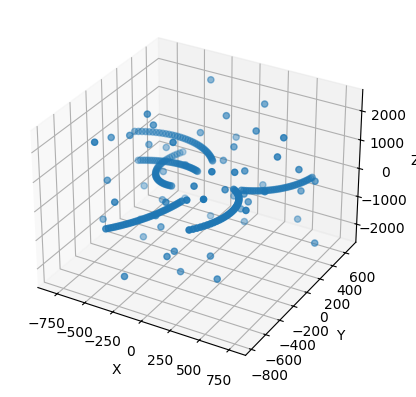

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_event(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = df['x']
    y = df['y']
    z = df['z']

    ax.scatter(x, y, z)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

draw_event(event)

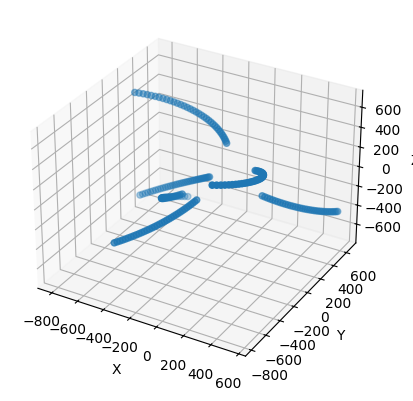

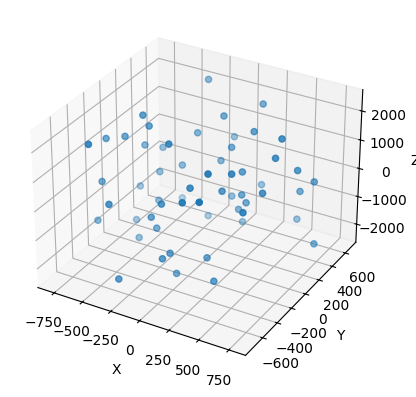

In [12]:
df_track = event.loc[event['track'] >= 0]
df_noise = event.loc[event['track'] == -1]

draw_event(df_track)
draw_event(df_noise)

## 2. Добавить цилиндрические координаты хитов вокруг оси z

In [13]:
from tracking.hit import add_cylindric_coordinates

add_cylindric_coordinates(event)

,x,y,z,layer,track,event_id,r,phi
0,-41.500954,-267.020066,45.116022,1,0,0,270.225915,-1.724985
1,-46.655014,-283.373472,38.283327,2,0,0,287.188466,-1.733974
2,-52.123845,-299.554467,31.522543,3,0,0,304.055544,-1.743076
3,-57.832385,-315.979892,24.567041,4,0,0,321.228699,-1.751818
4,-63.882239,-332.067215,17.544769,5,0,0,338.156141,-1.760852
...,...,...,...,...,...,...,...,...
263,-574.672475,-150.832254,1470.466143,19,-1,0,594.137040,-2.884916
264,-1.325803,406.449395,-1206.369595,8,-1,0,406.451557,1.574058
265,-225.931209,-337.829300,-514.026101,8,-1,0,406.415486,-2.160256
266,625.420664,58.590399,2251.964028,21,-1,0,628.159090,0.093409


## 3. Реализовать с помощью любого метода машинного обучения классификацию хитов на настоящие и шумовые. Визуализировать результат для одного тестового события. Посчитать f1_score классификации на тестовом датасете spdsim с параметрами по умолчанию.

In [15]:
import numpy as np
y_train = event['track'].to_numpy() 
y_train = np.where(y_train >= 0, 1, 0)
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [17]:
df_train = event.drop(['track', 'event_id'], axis=1)
df_train

,x,y,z,layer,r,phi
0,-41.500954,-267.020066,45.116022,1,270.225915,-1.724985
1,-46.655014,-283.373472,38.283327,2,287.188466,-1.733974
2,-52.123845,-299.554467,31.522543,3,304.055544,-1.743076
3,-57.832385,-315.979892,24.567041,4,321.228699,-1.751818
4,-63.882239,-332.067215,17.544769,5,338.156141,-1.760852
...,...,...,...,...,...,...
263,-574.672475,-150.832254,1470.466143,19,594.137040,-2.884916
264,-1.325803,406.449395,-1206.369595,8,406.451557,1.574058
265,-225.931209,-337.829300,-514.026101,8,406.415486,-2.160256
266,625.420664,58.590399,2251.964028,21,628.159090,0.093409


In [18]:
x_train = df_train.to_numpy()
x_train

array([[-4.15009544e+01, -2.67020066e+02,  4.51160219e+01,
         1.00000000e+00,  2.70225915e+02, -1.72498529e+00],
       [-4.66550143e+01, -2.83373472e+02,  3.82833275e+01,
         2.00000000e+00,  2.87188466e+02, -1.73397386e+00],
       [-5.21238452e+01, -2.99554467e+02,  3.15225434e+01,
         3.00000000e+00,  3.04055544e+02, -1.74307598e+00],
       ...,
       [-2.25931209e+02, -3.37829300e+02, -5.14026101e+02,
         8.00000000e+00,  4.06415486e+02, -2.16025594e+00],
       [ 6.25420664e+02,  5.85903986e+01,  2.25196403e+03,
         2.10000000e+01,  6.28159090e+02,  9.34089609e-02],
       [-4.24801159e+00, -5.25934339e+02, -1.24588050e+03,
         1.50000000e+01,  5.25951495e+02, -1.57887323e+00]])

### Генерация тестового датасета

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
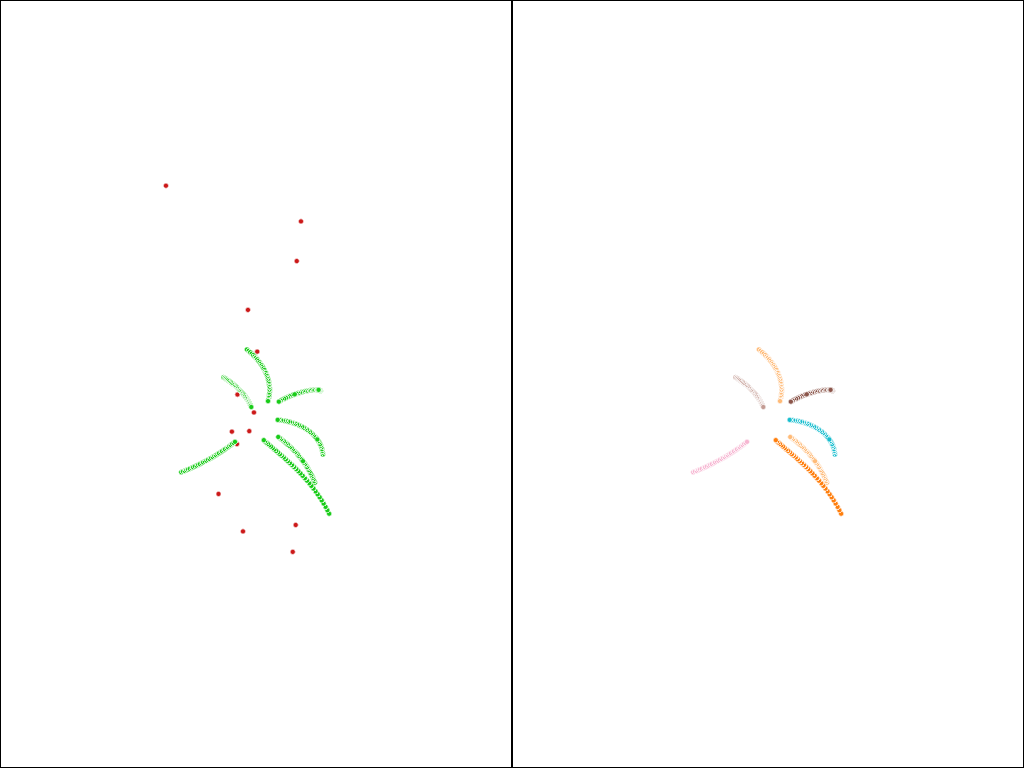

In [104]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from tracking.hit import add_cylindric_coordinates
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event_test = get_hits('spdsim', 1)
add_cylindric_coordinates(event_test)
plot_event(event_test)

In [105]:
event_test

,x,y,z,layer,track,event_id,r,phi
0,-35.591573,267.652656,-547.219739,1,0,0,270.008711,1.702997
1,-28.892482,285.533617,-571.550176,2,0,0,286.991676,1.671641
2,-21.063927,303.441357,-595.887234,3,0,0,304.171573,1.640102
3,-12.142795,320.874265,-620.343876,4,0,0,321.103942,1.608621
4,-2.106137,338.130962,-644.503933,5,0,0,338.137521,1.577025
...,...,...,...,...,...,...,...,...
254,-476.687210,683.030542,771.959826,33,-1,0,832.923417,2.180112
255,253.598821,401.249701,1595.666116,12,-1,0,474.672186,1.007163
256,268.120403,-472.109850,304.352333,16,-1,0,542.933018,-1.054299
257,491.800000,9.691161,-1732.662182,13,-1,0,491.895475,0.019703


In [106]:
y_test_right  = event_test['track'].to_numpy()
y_test_right = np.where(y_test_right >= 0, 1, 0)
y_test_right 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
df_test = event_test.drop(['track', 'event_id'], axis=1)
df_test

,x,y,z,layer,r,phi
0,-35.591573,267.652656,-547.219739,1,270.008711,1.702997
1,-28.892482,285.533617,-571.550176,2,286.991676,1.671641
2,-21.063927,303.441357,-595.887234,3,304.171573,1.640102
3,-12.142795,320.874265,-620.343876,4,321.103942,1.608621
4,-2.106137,338.130962,-644.503933,5,338.137521,1.577025
...,...,...,...,...,...,...
254,-476.687210,683.030542,771.959826,33,832.923417,2.180112
255,253.598821,401.249701,1595.666116,12,474.672186,1.007163
256,268.120403,-472.109850,304.352333,16,542.933018,-1.054299
257,491.800000,9.691161,-1732.662182,13,491.895475,0.019703


In [109]:
x_test = df_test.to_numpy()
x_test

array([[-3.55915729e+01,  2.67652656e+02, -5.47219739e+02,
         1.00000000e+00,  2.70008711e+02,  1.70299746e+00],
       [-2.88924818e+01,  2.85533617e+02, -5.71550176e+02,
         2.00000000e+00,  2.86991676e+02,  1.67164075e+00],
       [-2.10639273e+01,  3.03441357e+02, -5.95887234e+02,
         3.00000000e+00,  3.04171573e+02,  1.64010195e+00],
       ...,
       [ 2.68120403e+02, -4.72109850e+02,  3.04352333e+02,
         1.60000000e+01,  5.42933018e+02, -1.05429949e+00],
       [ 4.91800000e+02,  9.69116104e+00, -1.73266218e+03,
         1.30000000e+01,  4.91895475e+02,  1.97029422e-02],
       [ 2.18905015e+02, -3.22088210e+02,  9.03524820e+02,
         7.00000000e+00,  3.89435772e+02, -9.73863791e-01]])

### Классификация

In [110]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)

clf.fit(x_train, y_train)

RandomForestClassifier()

In [111]:
y_test = clf.predict(x_test)

### Визуализация

In [112]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [113]:
import pandas as pd

cls = pd.DataFrame(y_test, columns=['cluster'])

df_test = pd.concat([df_test, cls], axis=1)
df_test

,x,y,z,layer,r,phi,cluster
0,-35.591573,267.652656,-547.219739,1,270.008711,1.702997,0
1,-28.892482,285.533617,-571.550176,2,286.991676,1.671641,0
2,-21.063927,303.441357,-595.887234,3,304.171573,1.640102,0
3,-12.142795,320.874265,-620.343876,4,321.103942,1.608621,0
4,-2.106137,338.130962,-644.503933,5,338.137521,1.577025,0
...,...,...,...,...,...,...,...
254,-476.687210,683.030542,771.959826,33,832.923417,2.180112,0
255,253.598821,401.249701,1595.666116,12,474.672186,1.007163,0
256,268.120403,-472.109850,304.352333,16,542.933018,-1.054299,1
257,491.800000,9.691161,-1732.662182,13,491.895475,0.019703,0


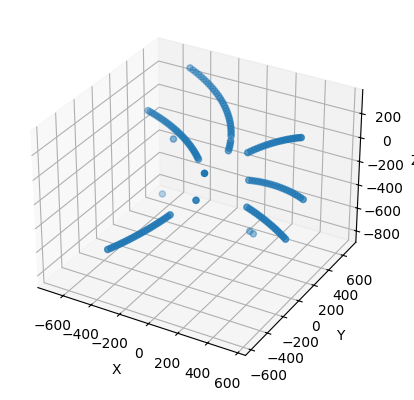

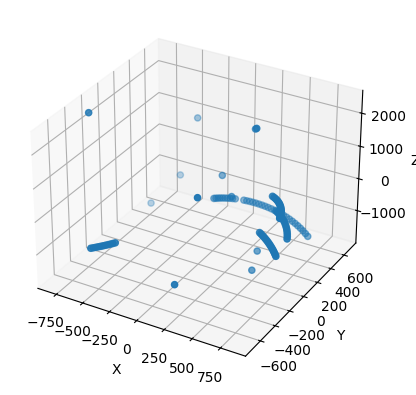

In [114]:
df_track = df_test.loc[df_test['cluster'] == 1]
df_noise = df_test.loc[df_test['cluster'] == 0]

draw_event(df_track)
draw_event(df_noise)

### Подсчет f1_score

In [115]:
import numpy as np
from sklearn.metrics import f1_score

f1_score(y_test_right, y_test)

0.755


### DecisionTreeClassifier

In [116]:
from sklearn.tree import DecisionTreeClassifier

first_tree = DecisionTreeClassifier(random_state=13, max_depth=2)
first_tree

DecisionTreeClassifier(max_depth=2, random_state=13)

In [117]:
try:
  first_tree.fit(x_train, y_train)
except Exception as e:
  print(e)

In [118]:
from sklearn.tree import export_text

tree_rules = export_text(first_tree, feature_names=list(df_train.columns))
print(tree_rules)

|--- z <= 710.04
|   |--- z <= -899.67
|   |   |--- class: 0
|   |--- z >  -899.67
|   |   |--- class: 1
|--- z >  710.04
|   |--- class: 0



In [119]:
prediction = first_tree.predict(x_test)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

### Визуализация

In [120]:
y_test_right

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [121]:
df_test.drop(['cluster'], axis=1, inplace=True)

In [122]:
cluster = pd.DataFrame(prediction, columns=['cluster'])
df_test = pd.concat([df_test, cluster], axis=1)
df_test

,x,y,z,layer,r,phi,cluster
0,-35.591573,267.652656,-547.219739,1,270.008711,1.702997,1
1,-28.892482,285.533617,-571.550176,2,286.991676,1.671641,1
2,-21.063927,303.441357,-595.887234,3,304.171573,1.640102,1
3,-12.142795,320.874265,-620.343876,4,321.103942,1.608621,1
4,-2.106137,338.130962,-644.503933,5,338.137521,1.577025,1
...,...,...,...,...,...,...,...
254,-476.687210,683.030542,771.959826,33,832.923417,2.180112,0
255,253.598821,401.249701,1595.666116,12,474.672186,1.007163,0
256,268.120403,-472.109850,304.352333,16,542.933018,-1.054299,1
257,491.800000,9.691161,-1732.662182,13,491.895475,0.019703,0


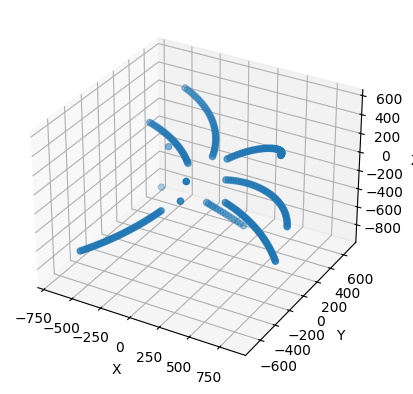

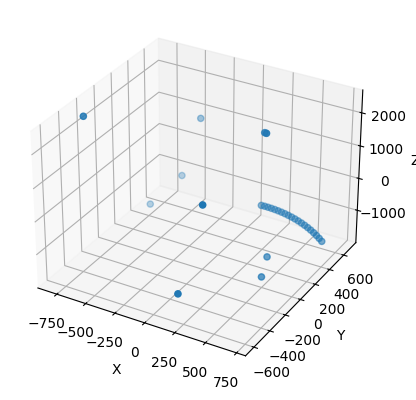

In [123]:
df_track = df_test.loc[df_test['cluster'] == 1]
df_noise = df_test.loc[df_test['cluster'] == 0]

draw_event(df_track)
draw_event(df_noise)

### Подсчет f1_score

In [124]:
from sklearn.metrics import f1_score

f1_score(y_test_right, prediction)


0.9073359073359073